# DSCI-508 Determining Trade Union Status - A Final Project
### Matt Snyder

In [530]:
import pandas as pd
import os  
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import decomposition
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from scipy.stats import boxcox
from sklearn.svm import SVC
from mpl_toolkits.mplot3d import Axes3D

## Objective

Utilizing custom TRAIN dataset build a model that can predict whether a data scientist will remain a USDU member.

**Additional Requirements**
* Data must be cleansed and normalized
* The project must contain charts and graphs, statistically describing the data features. At a minimum include a:
    * Box (or Violin) and Whisker plot of data features
    * Scree plot of primary components
    * Scatter plot of the data
    * Bivariate plots between key feature
* Final capstone model must predict UDSU loyalty using at least three of the following methods: Linear regression, Decision Tree, Support Vector Machine, Random Forest, Neural Network

## Contents

* [Load Data](#Load-Data)
* [Cleanse and Normalize](#Cleanse-and-Normalize)
* [Modeling with Decision Tree](#Modeling-with-decision-tree)
* [Modeling with Random Forest](#Modeling-with-Random-Forest)
* [Principal Component Analysis (PCA)](#Principal-Component-Analysis-(PCA))
* [Modeling with Logistic Regression](#Modeling-with-Logistic-Regression)
* [Modeling with Neural Net](#Modeling-with-Neural-Net)
* [Modeling with Support Vector Machine (SVM)](#Modeling-with-Support-Vector-Machine-(SVM))

## Load Data

In [2]:
df = pd.read_csv('Matthew-TRAIN.csv')
df.head()

,TrueID,SetID,gender,Management,USAcitizen,Married,MonthsInUnion,ContinuingEd,StateOfResidence,Connectivity,...,FeatureC,FeatureD,FeatureE,FeatureF,DuesFrequency,PaperlessBilling,PaymentMethod,MonthlyDues,TotalDues,LeftUnion
0,2453,Kelby1-17547,Male,0,Yes,Yes,28,Yes,IL,Fiber optic,...,No,No,Yes,Yes,One year,No,Electronic check,106.10,2847.4,Yes
1,4992,Kelby2-15008,Female,0,Yes,Yes,6,Yes,MO,DSL,...,No,No,No,No,Month-to-month,No,Mailed check,45.50,285.2,No
2,4909,Kelby3-15091,Female,0,Yes,No,71,Yes,IL,No,...,Maryville,Maryville,Maryville,Maryville,Two year,No,Mailed check,23.85,1672.1,No
3,6612,Kelby4-13388,Male,0,No,No,5,Yes,MO,Fiber optic,...,No,No,Yes,No,Month-to-month,Yes,Mailed check,80.10,398.55,No
4,1952,Kelby5-18048,Male,0,Yes,No,65,Yes,IL,Fiber optic,...,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),91.85,5940.85,Yes


<a id="cleanse"></a>
## Cleanse and Normalize

### Cleanse Entries
Make a histogram of every feature, not including the ID fields, to check for anomolous entries, such as misspellings, inconsistent capitalization, or the same thing represented two ways.  I did not find anything that needed cleansing

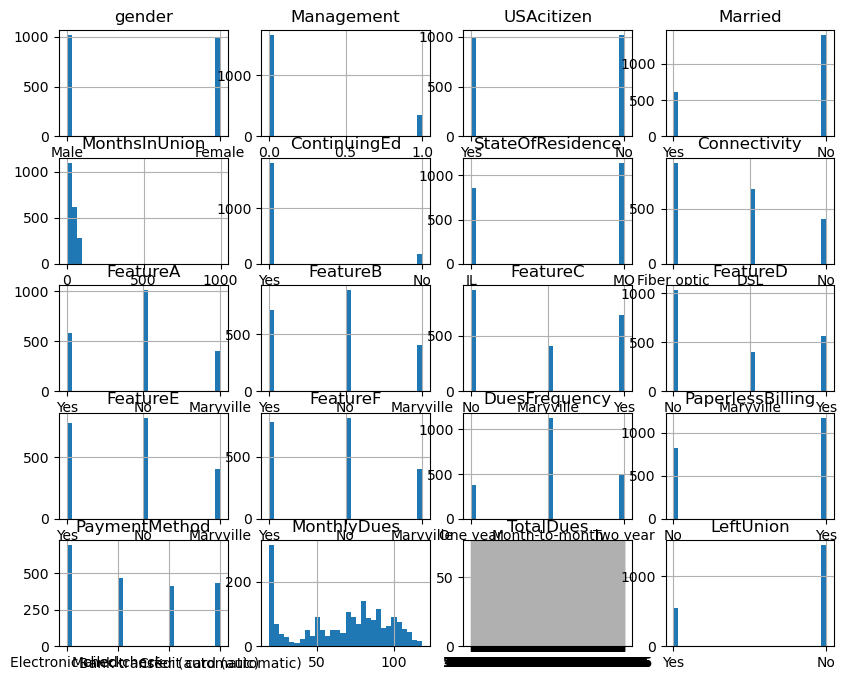

In [3]:
plt.figure(figsize=[10,8])
for i in range(2, len(df.columns)):
    plt.subplot(5,4,i-1)
    df.iloc[:, i].hist(bins=30)
    plt.title(df.columns[i])
plt.show()

### Cleanse Column Types
Look for columns that are object but should be numeric.  TotalDues is object.  When I tried to convert it to float, I discovered why: some entries contain spaces

In [4]:
df.dtypes

TrueID                int64
SetID                object
gender               object
Management            int64
USAcitizen           object
Married              object
MonthsInUnion         int64
ContinuingEd         object
StateOfResidence     object
Connectivity         object
FeatureA             object
FeatureB             object
FeatureC             object
FeatureD             object
FeatureE             object
FeatureF             object
DuesFrequency        object
PaperlessBilling     object
PaymentMethod        object
MonthlyDues         float64
TotalDues            object
LeftUnion            object
dtype: object

In [253]:
# Make TotalDues numeric
#   Due to presence of some empty strings, this gives error: df['TotalDues'] = df['TotalDues'].astype(float)
df['TotalDues'] = pd.to_numeric(df['TotalDues'], errors='coerce')

# replace NAN with mean of column
# Calculate the mean of 'col_A'
mean_total_dues = df['TotalDues'].mean()
df['TotalDues'] = df['TotalDues'].fillna(mean_total_dues)

### Normalize Numeric Features
First look for strong correlation between the features, which would allow me to quickly reduce dimensions.  I used the pairplot function of Seaborn.  I am also looking for predictors of the target.

Things that I observed:
* Months in Union is heavily clustered under 100, with only a handful of outliers. It appears that 60% of the outliers left the union, which differs from the overall tendency of only 27%, so there might be some predictive value.  Or, I could just ignore the outliers, by truncating those above 100 to 100.  I think I will truncate, and then normalize to numbers between 0 and 1 by dividing by 100.
* For each feature, the distribution is similar between left the union and did not.
* TotalDues is correlated with two other feaures: MonthlyDues and MonthsInUnion. It makes sense that TotalDues is an integral over MonthsInUnion of MonthlyDues, so there will be a correlation of some kind.  I think it would be possible to calculate the covariance, and prove that TotalDues redundant with the other two.  Because we have figured out a plan to normalize the other two, I will omit TotalDues from the model *for now*.
* Monthly dues are not uniformly distributed, and not normally either.  There are two peaks, looks like around 25 and 80.  I could convert all these numbers to 0 or 1, representing dues closer to 25 or dues closer to 80.  I think instead, I will normalize MonthlyDues to be in the range 0 to 1, by dividing by the max, which looks like 120.
* The montly dues peak at 25 is only present on the distribution of those who stayed in the union.  So I would expect monthly dues to be an important feature for prediction leave vs. stay.

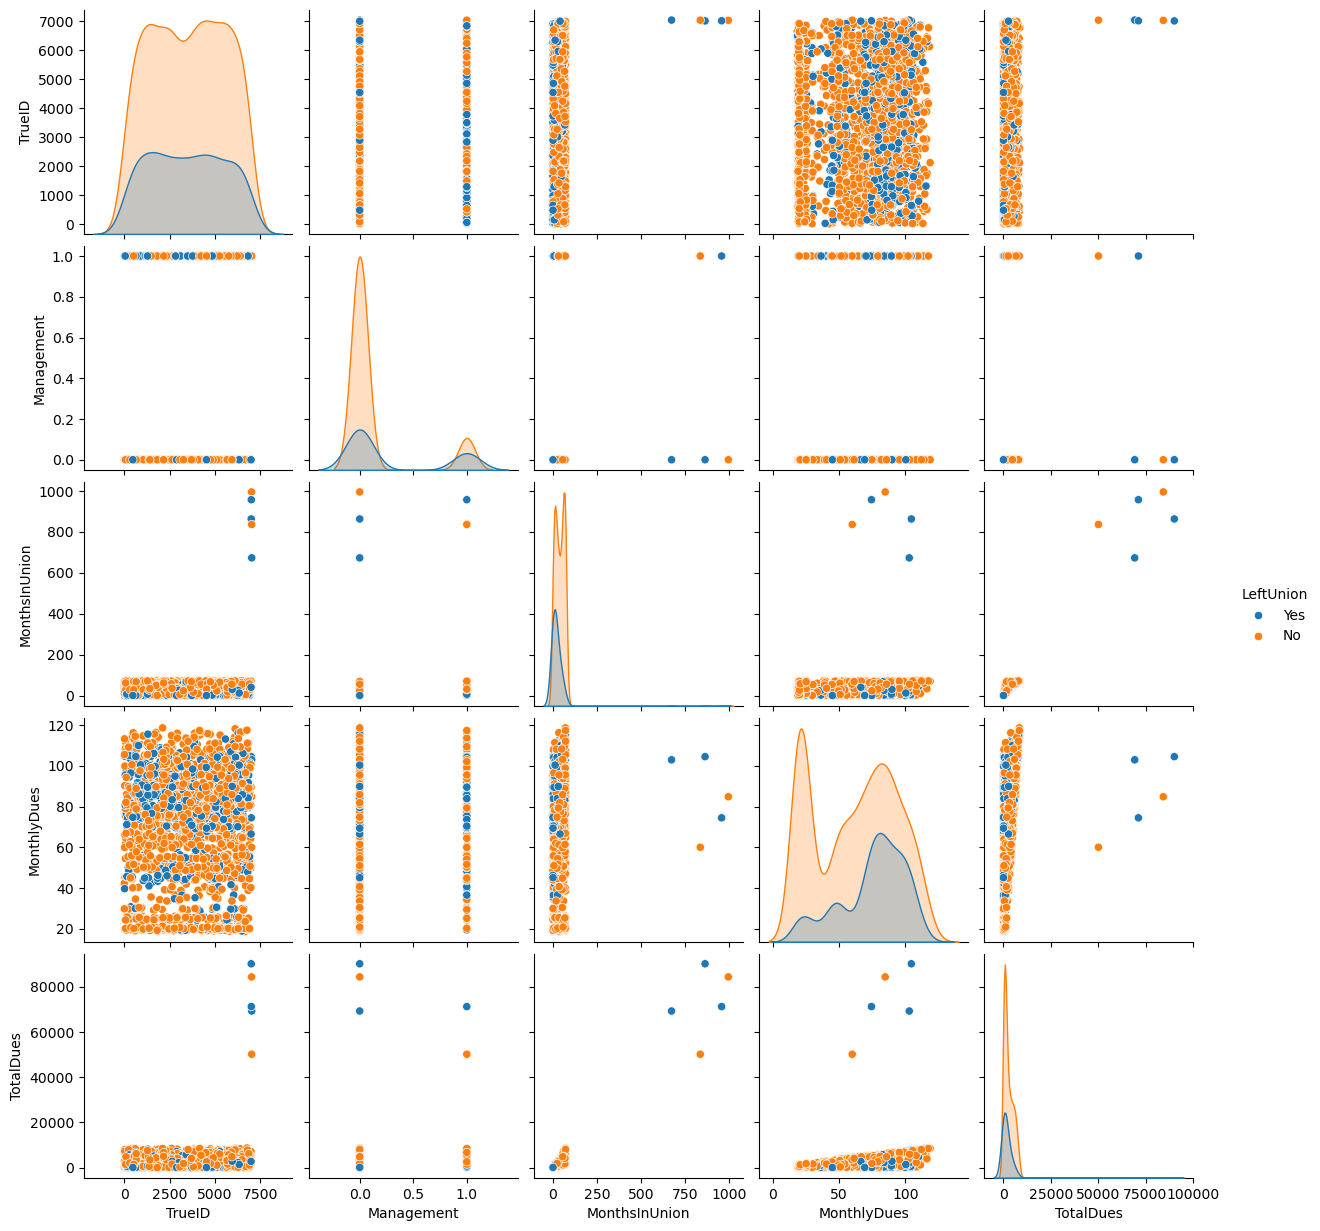

In [6]:
sns.pairplot(df, hue="LeftUnion")
plt.show()

**Percentage distribution of LeftUnion**

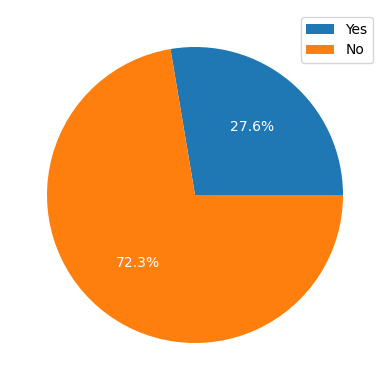

In [7]:
dist = df["LeftUnion"].value_counts().to_dict()
fig = plt.figure(figsize = (4,4))
ax = fig.add_subplot()
dist_sorted = sorted(dist.items(), reverse=True) # sort dictionary to get colors of No and Yes to match above charts
dist = dict(dist_sorted)
ax.pie(dist.values(), labels = dist.keys(), autopct = '%1.1f%%', textprops = {'fontsize': 10, 'color' : "white"})
plt.tight_layout()
plt.legend()
plt.show()

**Normalize Dues**

In [8]:
df['MonthlyDues_norm'] = np.clip(df['MonthlyDues'].values, 0, 120) / 120

**Normalize MonthsInUnion**

In [9]:
df['MonthsInUnion_norm'] = np.clip(df['MonthsInUnion'].values, 0, 100) / 100

**Violin plots of numeric features**

Skip TotalDues for now, since I have not yet addressed the outliners

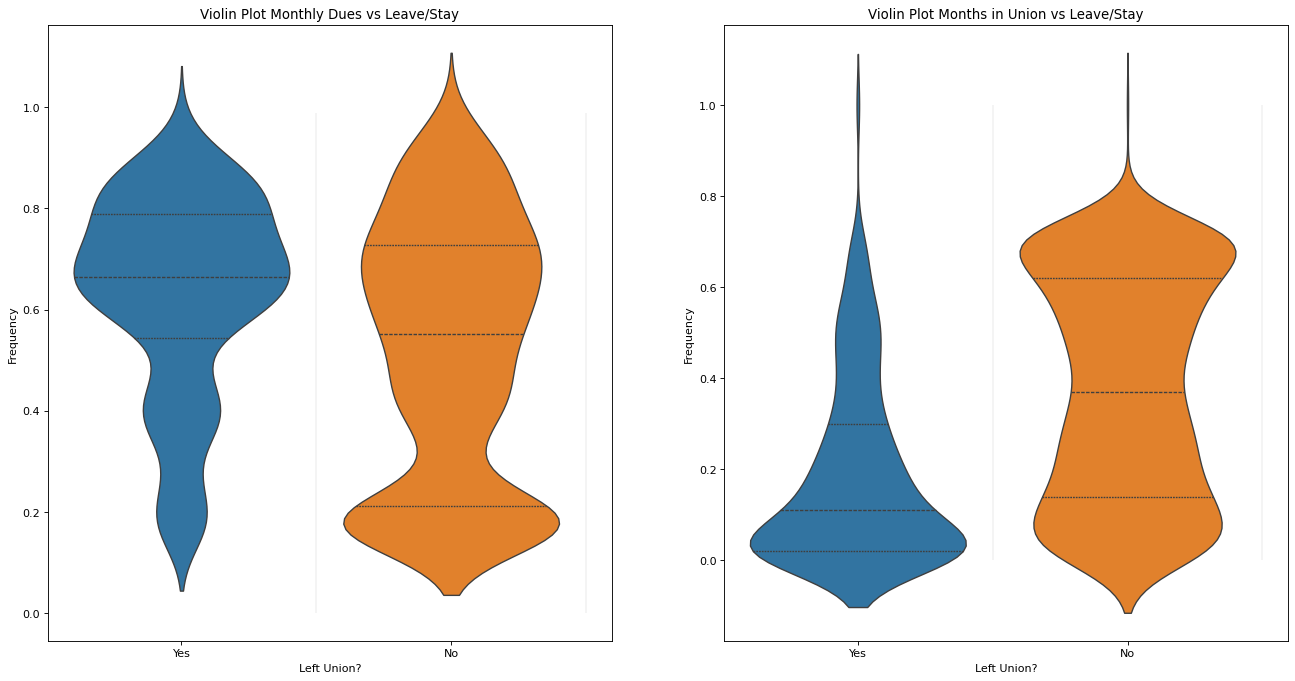

In [643]:
plt.figure(figsize = (20, 10), dpi= 80)

# Monthly Dues
plt.subplot(1,2,1)
sns.violinplot(x = "LeftUnion", y = "MonthlyDues_norm", data = df, density_norm = 'width', 
               inner = 'quartile',hue = "LeftUnion")
# add vertical dividers
ax = plt.gca()
xticks = ax.get_xticks()
for tick in xticks:
    ax.vlines(tick + 0.5, 0, np.max(df["MonthlyDues_norm"]), color = "grey", alpha = .1)
# add title, axis labels
plt.title("Violin Plot Monthly Dues vs Leave/Stay")
plt.ylabel('Frequency')
plt.xlabel('Left Union?')

# Months in Union
plt.subplot(1,2,2)
sns.violinplot(x = "LeftUnion", y = "MonthsInUnion_norm", data = df, density_norm = 'width', 
               inner = 'quartile',hue = "LeftUnion")
# add vertical dividers
ax = plt.gca()
xticks = ax.get_xticks()
for tick in xticks:
    ax.vlines(tick + 0.5, 0, np.max(df["MonthsInUnion_norm"]), color = "grey", alpha = .1)
# add title, axis labels
plt.title("Violin Plot Months in Union vs Leave/Stay")
plt.ylabel('Frequency')
plt.xlabel('Left Union?')

plt.show()

### Normalize Categorical Features

**Collect categorical features**

In [10]:
col_list = list( df.columns)
objList = []
for col in col_list:
    if df.dtypes[col] == object:
        objList.append(col)
objList

['SetID',
 'gender',
 'USAcitizen',
 'Married',
 'ContinuingEd',
 'StateOfResidence',
 'Connectivity',
 'FeatureA',
 'FeatureB',
 'FeatureC',
 'FeatureD',
 'FeatureE',
 'FeatureF',
 'DuesFrequency',
 'PaperlessBilling',
 'PaymentMethod',
 'LeftUnion']

**Use 1-hot encoding**

Also skip the ID column at the beginning, and the target value at the end, and omit redundant columns

In [119]:
# create columns for every possible categorical value
df_cats = pd.get_dummies(df[objList[1:-1]], prefix_sep='_', drop_first=False) # 1-hot, not triangular

# _Yes and _No column pairs are correlated and redundant, so remove the _No columns if there is also a _Yes column
column_list = list(df_cats.columns)
cleaner_column_list = [column for column in column_list if '_No' not in column or column.replace('_No', '_Yes') not in column_list]

# According to the data cleansing check I did, male and female are also redundant, since all responses have either male or female
cleaner_column_list = [column for column in cleaner_column_list if '_Male' not in column]

df_cats = df_cats.loc[:, cleaner_column_list]
print (cleaner_column_list)

df_cats.head()

['gender_Female', 'USAcitizen_Yes', 'Married_Yes', 'ContinuingEd_Yes', 'StateOfResidence_IL', 'StateOfResidence_MO', 'Connectivity_DSL', 'Connectivity_Fiber optic', 'Connectivity_No', 'FeatureA_Maryville', 'FeatureA_Yes', 'FeatureB_Maryville', 'FeatureB_Yes', 'FeatureC_Maryville', 'FeatureC_Yes', 'FeatureD_Maryville', 'FeatureD_Yes', 'FeatureE_Maryville', 'FeatureE_Yes', 'FeatureF_Maryville', 'FeatureF_Yes', 'DuesFrequency_Month-to-month', 'DuesFrequency_One year', 'DuesFrequency_Two year', 'PaperlessBilling_Yes', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']


,gender_Female,USAcitizen_Yes,Married_Yes,ContinuingEd_Yes,StateOfResidence_IL,StateOfResidence_MO,Connectivity_DSL,Connectivity_Fiber optic,Connectivity_No,FeatureA_Maryville,...,FeatureF_Maryville,FeatureF_Yes,DuesFrequency_Month-to-month,DuesFrequency_One year,DuesFrequency_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,False,True,True,True,True,False,False,True,False,False,...,False,True,False,True,False,False,False,False,True,False
1,True,True,True,True,False,True,True,False,False,False,...,False,False,True,False,False,False,False,False,False,True
2,True,True,False,True,True,False,False,False,True,True,...,True,False,False,False,True,False,False,False,False,True
3,False,False,False,True,False,True,False,True,False,False,...,False,False,True,False,False,True,False,False,False,True
4,False,True,False,True,True,False,False,True,False,False,...,False,False,True,False,False,True,True,False,False,False


### Combine numeric and categorical into one dataframe

In [389]:
X_df = pd.concat([df.loc[:, ['MonthsInUnion_norm', 'MonthlyDues_norm']], df_cats],axis=1)
X_df.head()

,MonthsInUnion_norm,MonthlyDues_norm,gender_Female,USAcitizen_Yes,Married_Yes,ContinuingEd_Yes,StateOfResidence_IL,StateOfResidence_MO,Connectivity_DSL,Connectivity_Fiber optic,...,FeatureF_Maryville,FeatureF_Yes,DuesFrequency_Month-to-month,DuesFrequency_One year,DuesFrequency_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.28,0.884167,False,True,True,True,True,False,False,True,...,False,True,False,True,False,False,False,False,True,False
1,0.06,0.379167,True,True,True,True,False,True,True,False,...,False,False,True,False,False,False,False,False,False,True
2,0.71,0.198750,True,True,False,True,True,False,False,False,...,True,False,False,False,True,False,False,False,False,True
3,0.05,0.667500,False,False,False,True,False,True,False,True,...,False,False,True,False,False,True,False,False,False,True
4,0.65,0.765417,False,True,False,True,True,False,False,True,...,False,False,True,False,False,True,True,False,False,False


In [121]:
y_df = df[['LeftUnion']]
y = y_df.values
y_df.head()

,LeftUnion
0,Yes
1,No
2,No
3,No
4,Yes


## Modeling with Decision Tree

### Divide training data into train and test
80% / 20%

In [271]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=0)

### Train model

In [272]:
clf=tree.DecisionTreeClassifier(max_leaf_nodes=None, criterion='gini')
clf=clf.fit(X_train,y_train)

### Make predictions, evaluate accuracy

In [273]:
predictions = clf.predict(X_train)
accuracy_train = (predictions == y_train[:, 0]).sum() / len(predictions)
predictions = clf.predict(X_test)
accuracy_test = (predictions == y_test[:, 0]).sum() / len(predictions)
print (f'accuracy with training data: {accuracy_train}')
print (f'accuracy with test data:     {accuracy_test}')

accuracy with training data: 0.999375
accuracy with test data:     0.745


### Try again with different max_leaf_nodes

In [125]:
clf2=tree.DecisionTreeClassifier(max_leaf_nodes=10, criterion='gini')
clf2=clf2.fit(X_train,y_train)

In [126]:
predictions = clf2.predict(X_train)
accuracy_train = (predictions == y_train[:, 0]).sum() / len(predictions)
predictions = clf2.predict(X_test)
accuracy_test = (predictions == y_test[:, 0]).sum() / len(predictions)
print (f'accuracy with training data: {accuracy_train}')
print (f'accuracy with test data:     {accuracy_test}')

accuracy with training data: 0.806875
accuracy with test data:     0.8125


### Assessment of first Decision Tree
Accuracy of the first decision tree model was extremely good with training data, but poor with test data, which is indicative of overtraining.  I experimented with different values for max_leaf_nodes, but the resulting accuracy was never better than 82%

### Try reducing features

Look at the most important features used by the decision tree, compare them, and try making more decision trees

**Obtain feature importance from the model**

In [127]:
importances = clf2.feature_importances_
feature_importances = pd.Series(importances, index=X_train.columns)
print(feature_importances.sort_values(ascending=False)[0:10])

DuesFrequency_Month-to-month    0.550154
MonthsInUnion_norm              0.202142
Connectivity_Fiber optic        0.141141
PaperlessBilling_Yes            0.038444
FeatureD_Yes                    0.022951
FeatureA_Maryville              0.022631
Married_Yes                     0.022536
StateOfResidence_IL             0.000000
ContinuingEd_Yes                0.000000
Connectivity_DSL                0.000000
dtype: float64


**Revisit Pair Plot and look for insights**

Do a new pair plot with the top features

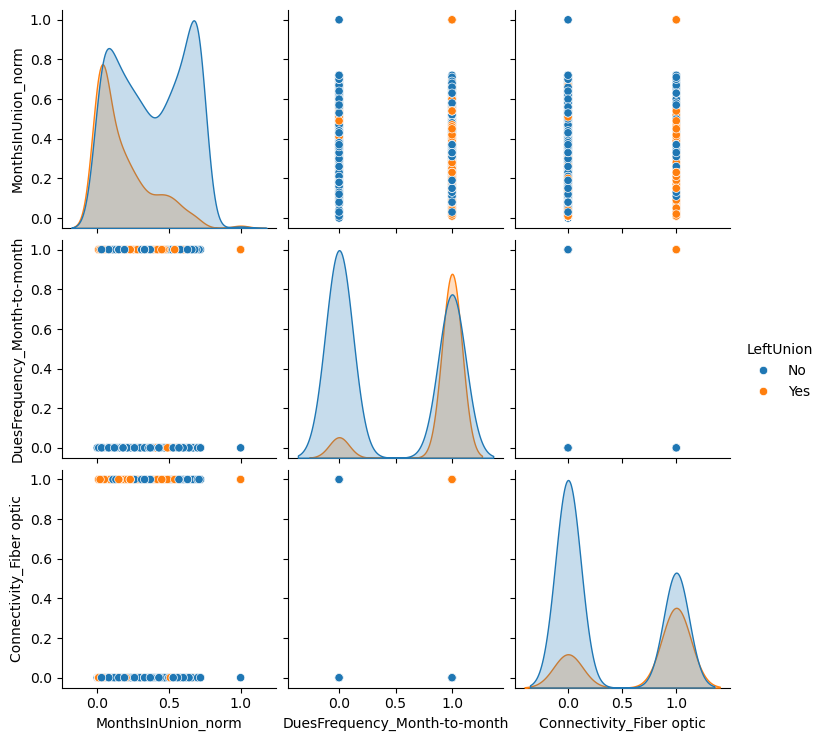

In [382]:
X_for_new_pair_plot = X_train.loc[:, ['MonthsInUnion_norm', 'DuesFrequency_Month-to-month', 'Connectivity_Fiber optic']]
X_for_new_pair_plot['LeftUnion'] = y_train[:, 0]
X_for_new_pair_plot.head()
sns.pairplot(X_for_new_pair_plot, hue="LeftUnion")
plt.show()

**Thoughts on Pair Plots**

The second pair plot and the first one both hilighted the different distribution of montly dues between leavers and stayers, which suggested montly dues would be a significant feature for prediction, and it was.   This second pair plot also shows a different density for dues frequency: more of the leavers were on a month-to-month dues schedule, which suggests dues frequency would be significant for prediction, and it was.

**Explore the apparent correlation between Dues Frequency and Connectivity**

The second pair plot also suggests a possible correlation between dues frequency and fiber connectivity.  The distribution of leavers and stayers is similar between the two features, i.e. more leavers are month-to-month, and more leavers have fiber.  Look for any overt evidence of correlation.

In [131]:
# count the number of members with combinations of the dues and connectivity values
combo_matrix = []
combo_matrix.append([x[0] and x[1] for x in X_for_new_pair_plot.loc[:, ['DuesFrequency_Month-to-month', 'Connectivity_Fiber optic']].values])
combo_matrix.append([x[0] and not x[1] for x in X_for_new_pair_plot.loc[:, ['DuesFrequency_Month-to-month', 'Connectivity_Fiber optic']].values])
combo_matrix.append([not x[0] and x[1] for x in X_for_new_pair_plot.loc[:, ['DuesFrequency_Month-to-month', 'Connectivity_Fiber optic']].values])
combo_matrix.append([not x[0] and not x[1] for x in X_for_new_pair_plot.loc[:, ['DuesFrequency_Month-to-month', 'Connectivity_Fiber optic']].values])
labels = ['M to M and Fiber', 'M to M and no Fiber', 'not M to M and Fiber', 'not M to M and no Fiber']
sums = np.sum(combo_matrix, axis=1)

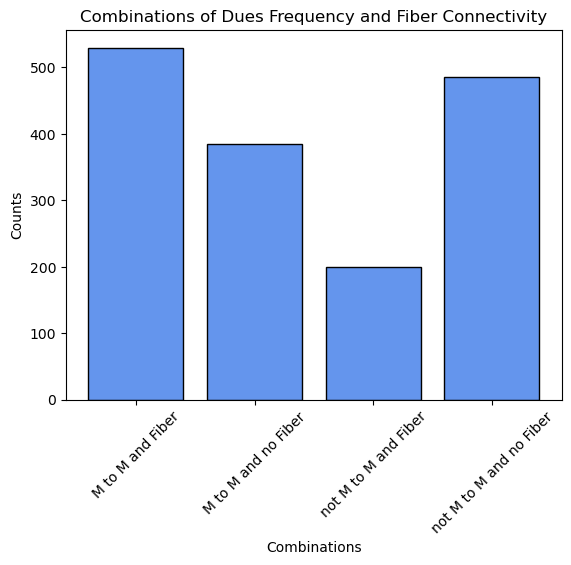

In [132]:
# Make a bar chart of the combinations
plt.bar(x=labels, height=sums, color='cornflowerblue', edgecolor='black')
plt.xlabel('Combinations')
plt.xticks(rotation=45)
plt.ylabel('Counts')
plt.title('Combinations of Dues Frequency and Fiber Connectivity')
plt.show()

**Thoughts on relationship between fiber and month-to-month dues**

Clearly there is a mild correlation, because for most members, the features track: either the member is month-to-month and has fiber, or the member is not month-to-month and does not have fiber.  But there are still plenty of members with the other two combinations.  It is not a clear correlation.

**Try using just the top 2 features in the decision tree**

In [128]:
X_train_r = X_train.loc[:, ['MonthsInUnion_norm', 'DuesFrequency_Month-to-month']]
X_test_r = X_test.loc[:, ['MonthsInUnion_norm', 'DuesFrequency_Month-to-month']]
X_train_r.head()

,MonthsInUnion_norm,DuesFrequency_Month-to-month
582,0.22,True
159,0.14,False
1827,0.27,True
318,0.32,True
708,0.09,True


In [129]:
# train
clf3=tree.DecisionTreeClassifier(max_leaf_nodes=None, criterion='gini')
clf3=clf3.fit(X_train_r,y_train)
# test
predictions = clf3.predict(X_train_r)
accuracy_train = (predictions == y_train[:, 0]).sum() / len(predictions)
predictions = clf3.predict(X_test_r)
accuracy_test = (predictions == y_test[:, 0]).sum() / len(predictions)
print (f'accuracy with training data: {accuracy_train}')
print (f'accuracy with test data:     {accuracy_test}')

accuracy with training data: 0.769375
accuracy with test data:     0.745


### Conclusion

A decision tree using only the top two features, *MonthsInUnion* and *DuesFrequency*, is not as good as the model trained on all features, but it is still surprisingly good.  And it is maybe intuitive, that the dues payment schedule might influence lapsing.  In this case, you might conclude that people are leaving the union not intentionally, but accidentally when they just neglect to pay dues. 

## Modeling with Random Forest

Since the Decision Tree model showed signs of being overtrained, use a random forest to alleviate the effects of overtraining

### Train Model

In [177]:
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train[:,0])

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=0)

In [178]:
# Print the name and gini importance of each feature
feat_labels = list(df_cats.columns)
ginis = []
for feature in zip(feat_labels, clf.feature_importances_):
    ginis.append(feature)
ginis = np.array(ginis)
ginis = np.sort(ginis, axis=1)
ginis

array([['0.2137057811813604', 'gender_Female'],
       ['0.19667046360107734', 'USAcitizen_Yes'],
       ['0.03370478204586883', 'Married_Yes'],
       ['0.03240184935722618', 'ContinuingEd_Yes'],
       ['0.02554348269146492', 'StateOfResidence_IL'],
       ['0.008204221677960078', 'StateOfResidence_MO'],
       ['0.015251691278000325', 'Connectivity_DSL'],
       ['0.014793454357093757', 'Connectivity_Fiber optic'],
       ['0.013351978618037693', 'Connectivity_No'],
       ['0.029694179828655423', 'FeatureA_Maryville'],
       ['0.00465707911766999', 'FeatureA_Yes'],
       ['0.004704373004503276', 'FeatureB_Maryville'],
       ['0.02755734223960684', 'FeatureB_Yes'],
       ['0.004927404553736767', 'FeatureC_Maryville'],
       ['0.02831657710888574', 'FeatureC_Yes'],
       ['0.004957358646981682', 'FeatureD_Maryville'],
       ['0.023353126317242855', 'FeatureD_Yes'],
       ['0.004731441135959672', 'FeatureE_Maryville'],
       ['0.026092505528029566', 'FeatureE_Yes'],
       ['

### Make predictions, evaluate accuracy

In [179]:
predictions = clf.predict(X_train)
accuracy_train = (predictions == y_train[:, 0]).sum() / len(predictions)
predictions = clf.predict(X_test)
accuracy_test = (predictions == y_test[:, 0]).sum() / len(predictions)
print (f'accuracy with training data: {accuracy_train}')
print (f'accuracy with test data:     {accuracy_test}')

accuracy with training data: 0.999375
accuracy with test data:     0.8125


### Try again with different max depth

In [209]:
# create model and train
clf2 = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1, max_depth=5)
clf2.fit(X_train, y_train[:,0])

# make predictions, evaluate accuracy
predictions = clf2.predict(X_train)
accuracy_train = (predictions == y_train[:, 0]).sum() / len(predictions)
predictions = clf2.predict(X_test)
accuracy_test = (predictions == y_test[:, 0]).sum() / len(predictions)
print (f'accuracy with training data: {accuracy_train}')
print (f'accuracy with test data:     {accuracy_test}')

accuracy with training data: 0.81
accuracy with test data:     0.8325


### Tray again with fewer features

**Obtain feature importance from the model**

In [183]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.15
sfm = SelectFromModel(clf2, threshold=0.15)

# Train the selector
sfm.fit(X_train, y_train[:,0])

# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

gender_Female
DuesFrequency_Two year


**Try using just the top 2 features to train the model**

In [170]:
X_train_r = X_train.loc[:, ['gender_Female', 'DuesFrequency_Two year']]
X_test_r = X_test.loc[:, ['gender_Female', 'DuesFrequency_Two year']]
X_train_r.head()

,gender_Female,DuesFrequency_Two year
582,False,False
159,True,False
1827,True,False
318,False,False
708,True,False


In [173]:
# create model and train
clf3 = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1, max_depth=5)
clf3.fit(X_train_r, y_train[:,0])
# test
predictions = clf3.predict(X_train_r)
accuracy_train = (predictions == y_train[:, 0]).sum() / len(predictions)
predictions = clf3.predict(X_test_r)
accuracy_test = (predictions == y_test[:, 0]).sum() / len(predictions)
print (f'accuracy with training data: {accuracy_train}')
print (f'accuracy with test data:     {accuracy_test}')

accuracy with training data: 0.71375
accuracy with test data:     0.7625


### Conclusion
I expected the Random Forest model to exhibit less overtraining than the decision tree, but the results were very similar.  The first model had overtraining symptoms: almost 100% accuracy on the training data, but only 81% on the test data.  I was able to reduce the overtraining by reducing the max depth.  A third model made with a 2-feature subset of the training data also behaved similarly to the decision tree, but does give slightly better accuracy: 76% compared to 75%.

It's very interesting that the random forest training process ranked the importance of the features differently than the decision tree, and the top two most important features were different, although the dues two-year feature is no doubt negatively correlated with the dues month-to-month feature (they are never both true). And it's interesting that a model using these different features has about the same accuracy as the decision tree using two different features.

## Principal Component Analysis (PCA) 
The above methods of identifying the most important features were inconsistent, and we know there is some latent covariance between the columns.  Try PCA to find derived features that reduce number of features by taking into account their covariance.

### Bring Back TotalDues

I had decided to remove TotalDues during data cleansing, knowing there is some (non-linear) correlation between total dues, monthly dues, and months in union.  Bring it back now, because PCA can take into account that correlation.

There are some extreme outliners of total dues, but taking the log makes the distribution more compact.

**Examine uneven distribution of total dues**

In [254]:
total_dues = df['TotalDues'].values
print (f'Total dues range from {np.min(total_dues)} to {np.max(total_dues)}')

Total dues range from 18.85 to 90183.5


In [384]:
log_total_dues = np.log(df['TotalDues'].values)
total_dues_truncated = np.clip(df['TotalDues'].values, a_min=0, a_max=10000)

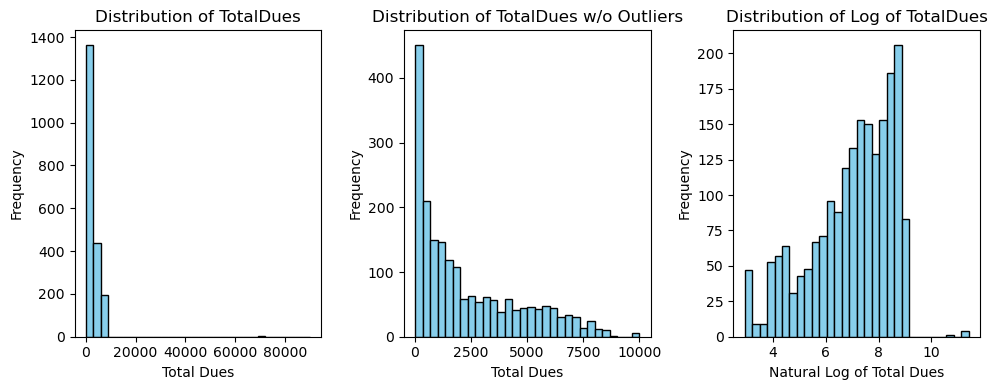

In [385]:
# two side-by-side plots
plt.figure(figsize=[10,4])

# total dues raw
plt.subplot(1,3,1)
plt.title('Distribution of TotalDues')
plt.hist(df['TotalDues'].values, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Total Dues')
plt.ylabel('Frequency')

# total dues truncated
plt.subplot(1,3,2)
plt.title('Distribution of TotalDues w/o Outliers')
plt.hist(total_dues_truncated, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Total Dues')
plt.ylabel('Frequency')

# log of total dues
plt.subplot(1,3,3)
plt.title('Distribution of Log of TotalDues')
plt.hist(log_total_dues, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Natural Log of Total Dues')
plt.ylabel('Frequency')

# Call plt.tight_layout() and then use plt.show() to display the figure.
plt.tight_layout()
plt.show()

**Violin Plot of TotalDues w/o Outliers**

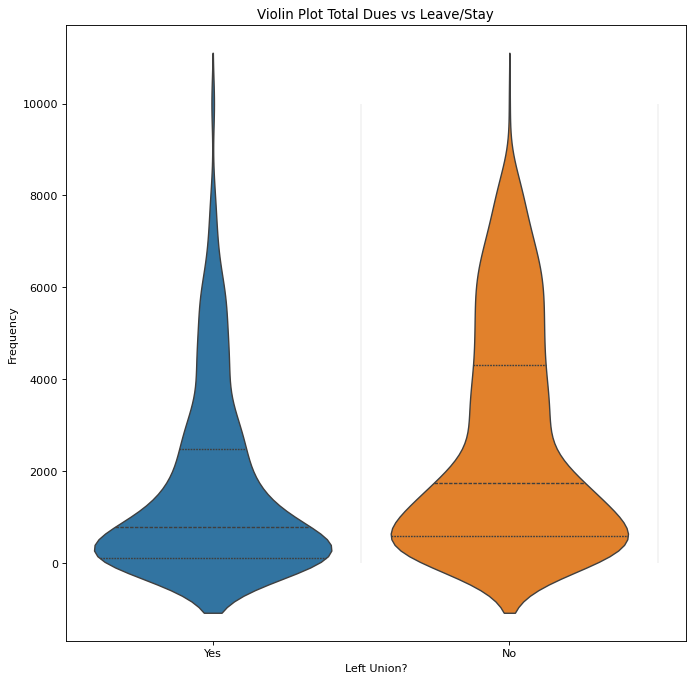

In [691]:
plt.figure(figsize = (10, 10), dpi= 80)
df['TotalDues_trunc'] = total_dues_truncated
sns.violinplot(x = "LeftUnion", y = "TotalDues_trunc", data = df, density_norm = 'width', 
               inner = 'quartile',hue = "LeftUnion")
# add vertical dividers
ax = plt.gca()
xticks = ax.get_xticks()
for tick in xticks:
    ax.vlines(tick + 0.5, 0, np.max(df["TotalDues_trunc"]), color = "grey", alpha = .1)
# add title, axis labels
plt.title("Violin Plot Total Dues vs Leave/Stay")
plt.ylabel('Frequency')
plt.xlabel('Left Union?')
# display
plt.show()

**Transform and normalize total dues**

There are two aspects of total dues that might bias the model if untreated: 1. a small handful of outliers that are orders of magnitude larger than most, and 2. even without outliers, the distribution has a long tail, like a Pareto distribution.  A little research shows that the Box Cox transform is a way on converting a Pareto-like distribution into a normal distribution.  I did some experiments with and without this transform, and the models are about 2% more accurate with it.

Text(0, 0.5, 'Frequency')

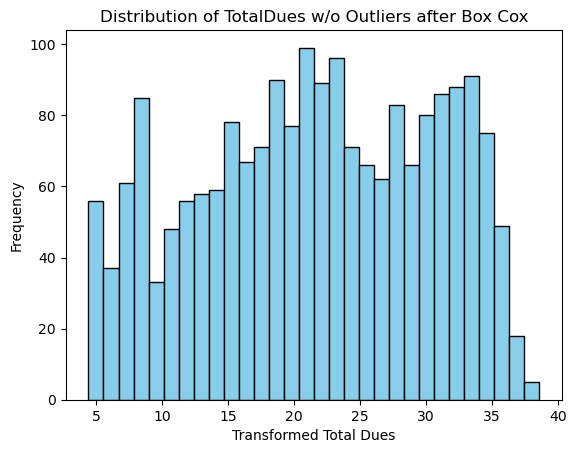

In [692]:
# transform
total_dues_box_cox, optimal_lambda = boxcox(total_dues_truncated)
# plot new distribution
plt.title('Distribution of TotalDues w/o Outliers after Box Cox')
plt.hist(total_dues_box_cox, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Transformed Total Dues')
plt.ylabel('Frequency')

In [693]:
# Normalize transformed dues to between 0 and 1, and add it to dataframe for training
max_total_dues = np.max(total_dues_box_cox)
X_df['TotalDuesBoxCox'] = total_dues_box_cox / max_total_dues
X_df.head()

,MonthsInUnion_norm,MonthlyDues_norm,gender_Female,USAcitizen_Yes,Married_Yes,ContinuingEd_Yes,StateOfResidence_IL,StateOfResidence_MO,Connectivity_DSL,Connectivity_Fiber optic,...,FeatureF_Yes,DuesFrequency_Month-to-month,DuesFrequency_One year,DuesFrequency_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TotalDuesBoxCox
0,0.28,0.884167,False,True,True,True,True,False,False,True,...,True,False,True,False,False,False,False,True,False,0.692604
1,0.06,0.379167,True,True,True,True,False,True,True,False,...,False,True,False,False,False,False,False,False,True,0.334979
2,0.71,0.198750,True,True,False,True,True,False,False,False,...,False,False,False,True,False,False,False,False,True,0.589846
3,0.05,0.667500,False,False,False,True,False,True,False,True,...,False,True,False,False,True,False,False,False,True,0.374628
4,0.65,0.765417,False,True,False,True,True,False,False,True,...,False,True,False,False,True,True,False,False,False,0.860250


**Re-sample training and test**

Note: I tried stratify=y at this point, because a majority of the data has the 'No' label, and I thought having equal samples of Yes and No would benefit modeling.  But the result was that all the models were 5% worse with stratified data.

In [694]:
# Re-sample training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=0)

### PCA Transformation

In [768]:
pca = decomposition.PCA(n_components=6) # guess to start with 6 components
pca.fit(X_train)
X_train_pc = pca.transform(X_train)

### Scree Plot of Eigenvalues

See how many we need before diminishing returns

eigenvalues: [1.61972825 0.80894711 0.64428997 0.30497497 0.26250068 0.25127117] 
eigenvalue percentages: [0.6696 0.167  0.1059 0.0237 0.0176 0.0161]


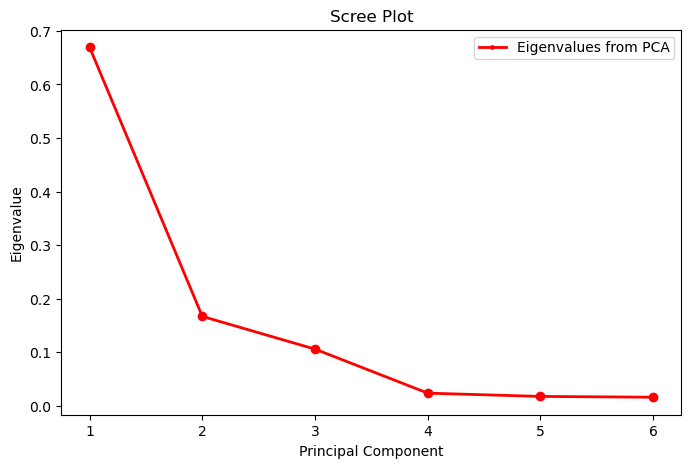

In [770]:
# get eigenvalues
raw_eigVal = pca.explained_variance_
# convert eigenvalues to percents
eigvals=np.round(sorted(raw_eigVal**2 / np.sum(raw_eigVal**2),key=abs,reverse=True),4) 
print(f'eigenvalues: {raw_eigVal} \neigenvalue percentages: {eigvals}')
fig = plt.figure(figsize=(8,5))
plt.plot(np.arange(6)+1, eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
leg = plt.legend(['Eigenvalues from PCA'], loc='best', borderpad=0.3, markerscale=0.4)
plt.show()

### 3D Plot in PCA-transformed Space

We can use PCA to finally visualize how the yes's and no's are distributed in a 3D plot, but for this we need exactly 3 components

**Redo the PCA with 3 components**

In [697]:
pca = decomposition.PCA(n_components=3)
pca.fit(X_train)
X_train_3 = pca.transform(X_train)

**Plot Points in 3D**

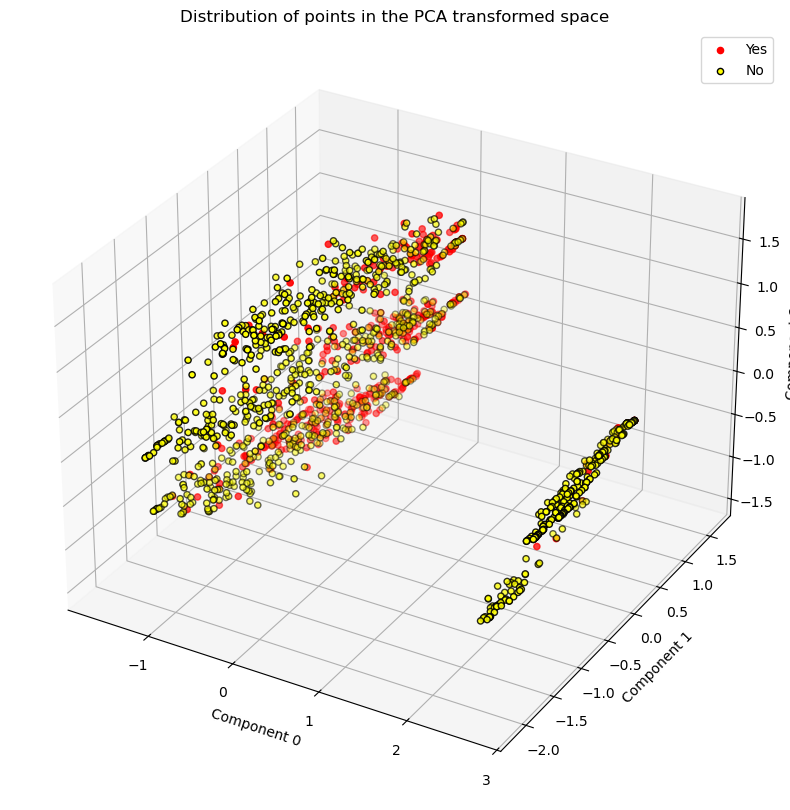

In [698]:
fig = plt.figure(figsize=(16,10))
# A modern way to add a 3D subplot is using the 'projection' keyword
ax = fig.add_subplot(projection='3d') 

# # map yes and no to colors
# y_numbers = [0.9 if value == 'Yes' else 0.42 for value in y_train[:,0]]
# rgba_colors = spectral_cmap(y_numbers)

# select the yes and no points separately
sel_yes = y_train[:,0] == 'Yes'
sel_no = y_train[:,0] == 'No'

# Plot the yes and no points with different colors
ax.scatter(X_train_3[sel_yes, 0], X_train_3[sel_yes, 1], X_train_3[sel_yes, 2], c='red', label='Yes')
ax.scatter(X_train_3[sel_no, 0], X_train_3[sel_no, 1], X_train_3[sel_no, 2], c='yellow', edgecolor='k', label='No')

# axis labels, our 3 new eigenvectors
ax.set_xlabel('Component 0')
ax.set_ylabel('Component 1')
ax.set_zlabel('Component 2')

# title, legend, and display
ax.set_title('Distribution of points in the PCA transformed space')
plt.legend()
plt.show()

**3D Plot from side, front, top**

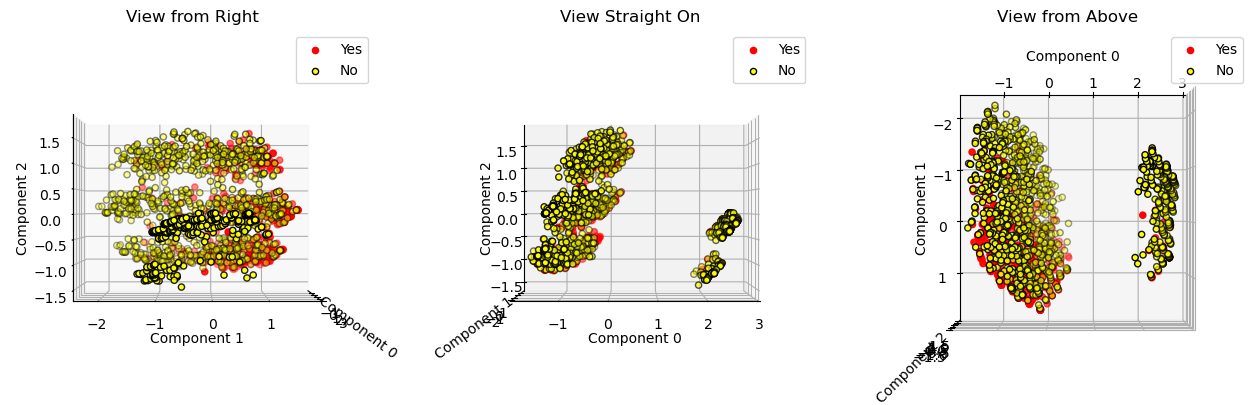

In [699]:
fig = plt.figure(figsize=(16,10))
# y_numbers = [0.9 if value == 'Yes' else 0.42 for value in y_train[:,0]]
# rgba_colors = spectral_cmap(y_numbers)
# sel_yes = y_train[:,0] == 'Yes'
# sel_no = y_train[:,0] == 'No'

# A modern way to add a 3D subplot is using the 'projection' keyword
ax = fig.add_subplot(1,3,1, projection='3d') 
ax.scatter(X_train_3[sel_yes, 0], X_train_3[sel_yes, 1], X_train_3[sel_yes, 2], c='red', label='Yes')
ax.scatter(X_train_3[sel_no, 0], X_train_3[sel_no, 1], X_train_3[sel_no, 2], c='yellow', edgecolor='k', label='No')
ax.view_init(0, 0)
ax.set_xlabel('Component 0')
ax.set_ylabel('Component 1')
ax.set_zlabel('Component 2')
ax.set_title('View from Right')
plt.legend()

# rotated
ax = fig.add_subplot(1,3,2, projection='3d') 
ax.scatter(X_train_3[sel_yes, 0], X_train_3[sel_yes, 1], X_train_3[sel_yes, 2], c='red', label='Yes')
ax.scatter(X_train_3[sel_no, 0], X_train_3[sel_no, 1], X_train_3[sel_no, 2], c='yellow', edgecolor='k', label='No')
ax.view_init(0, -90)
ax.set_xlabel('Component 0')
ax.set_ylabel('Component 1')
ax.set_zlabel('Component 2')
ax.set_title('View Straight On')
plt.legend()

# rotated the other way
ax = fig.add_subplot(1,3,3, projection='3d') 
ax.scatter(X_train_3[sel_yes, 0], X_train_3[sel_yes, 1], X_train_3[sel_yes, 2], c='red', label='Yes')
ax.scatter(X_train_3[sel_no, 0], X_train_3[sel_no, 1], X_train_3[sel_no, 2], c='yellow', edgecolor='k', label='No')
ax.view_init(-90, -90)
ax.set_xlabel('Component 0')
ax.set_ylabel('Component 1')
ax.set_zlabel('Component 2')
ax.set_title('View from Above')
plt.legend()

# Display the plot
plt.show()

### Assessment

From this visualization, we can see why it has been so hard to make a predictive model.  With the 3-component PCA, there is some helpful clumping, but the yes's and no's are still very intermixed.  Next we will use a 4-component PCA, and produce more models.

### Redo the PCA with 4 Components

The Scree plot shows a drastic reduction in variance attributed to the eigenvectors after 4, so remake the transform with only 4 components

In [730]:
pca = decomposition.PCA(n_components=4)
pca.fit(X_train)
X_train_pc = pca.transform(X_train)
X_test_pc = pca.transform(X_test)

### Redo the Random Forest model

In [731]:
# create model and train
clf4 = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1, max_depth=5)
clf4.fit(X_train_pc, y_train[:,0])
# test
predictions = clf4.predict(X_train_pc)
accuracy_train = (predictions == y_train[:, 0]).sum() / len(predictions)
predictions = clf4.predict(X_test_pc)
accuracy_test = (predictions == y_test[:, 0]).sum() / len(predictions)
print (f'accuracy with training data: {accuracy_train}')
print (f'accuracy with test data:     {accuracy_test}')

accuracy with training data: 0.815
accuracy with test data:     0.8275


### Conclusion

The number of principal components needed to capture most of the variance is 4, which seems reasonable, given that the decision tree and random forest models seemed to work tolerably with only 2 features.  However, the PCA-transformed training set did not produce a better random forest than the original training set.  I am surprised that the total dues numeric column did not seem to help the model.

Next, we will try the PCA-transformed training set with a logistic regression model.

## Modeling with Logistic Regression

### Train model with and without PCA transformation

In [732]:
model = LogisticRegression(solver='lbfgs', penalty=None, max_iter=5000) # default max_iter = 100
model.fit(X_train, y_train[:,0])
model_pc = LogisticRegression(solver='lbfgs', penalty=None, max_iter=5000) # default max_iter = 100
model_pc.fit(X_train_pc, y_train[:,0])

LogisticRegression(max_iter=5000, penalty=None)

### Make predictions, evaluate accuracy *without* PCA

In [733]:
predictions = model.predict(X_train)
accuracy_train = (predictions == y_train[:, 0]).sum() / len(predictions)
predictions = model.predict(X_test)
accuracy_test = (predictions == y_test[:, 0]).sum() / len(predictions)
print (f'accuracy with training data: {accuracy_train}')
print (f'accuracy with test data:     {accuracy_test}')

accuracy with training data: 0.8
accuracy with test data:     0.815


### Make predictions, evaluate accuracy *with* PCA

In [734]:
predictions = model_pc.predict(X_train_pc)
accuracy_train = (predictions == y_train[:, 0]).sum() / len(predictions)
predictions = model_pc.predict(X_test_pc)
accuracy_test = (predictions == y_test[:, 0]).sum() / len(predictions)
print (f'accuracy with training data: {accuracy_train}')
print (f'accuracy with test data:     {accuracy_test}')

accuracy with training data: 0.776875
accuracy with test data:     0.825


### Conclusion

PCA is promising, since the accuracy of the models is comparable to models made with the full set of features.  It has not provided an improvement yet, but the reduced feature set will facilitate the remaining two modeling attempts: neural net and SVM.

## Modeling with Neural Net

### Create and train model

In [721]:
mlp = MLPClassifier(hidden_layer_sizes=(50,10), activation='logistic', max_iter=5000)
mlp.fit(X_train_pc, y_train[:,0])

MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 10), max_iter=5000)

### Make predictions, evaluate accuracy

In [722]:
predictions = mlp.predict(X_train_pc)
accuracy_train = (predictions == y_train[:, 0]).sum() / len(predictions)
predictions = mlp.predict(X_test_pc)
accuracy_test = (predictions == y_test[:, 0]).sum() / len(predictions)
print (f'accuracy with training data: {accuracy_train}')
print (f'accuracy with test data:     {accuracy_test}')

accuracy with training data: 0.776875
accuracy with test data:     0.8125


### Seek optimal neural net parameters using grid search

With grid search, we guess a series of values for each parameter, and all combinations are attempted, to find the model with the best predictive score

In [711]:
if False: # don't do this every time
    param_grid = {
        'hidden_layer_sizes': [(50,), (50, 10), (50, 20, 10), (100, 50, 25), (150, 100, 35)],
        'activation': ['relu', 'tanh', 'logistic'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.005, 0.095, 0.1, 0.15]
    }
    
    mlp = MLPClassifier(max_iter=5000) # Increase max_iter for convergence
    grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_pc, y_train[:, 0])
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score: {grid_search.best_score_}")

In [736]:
mlp = MLPClassifier(hidden_layer_sizes=(50, 20, 10), activation='tanh', max_iter=5000, solver='adam', alpha=0.1)
mlp.fit(X_train_pc, y_train[:,0])

predictions = mlp.predict(X_train_pc)
accuracy_train = (predictions == y_train[:, 0]).sum() / len(predictions)
predictions = mlp.predict(X_test_pc)
accuracy_test = (predictions == y_test[:, 0]).sum() / len(predictions)
print (f'accuracy with training data: {accuracy_train}')
print (f'accuracy with test data:     {accuracy_test}')

accuracy with training data: 0.78375
accuracy with test data:     0.8425


### Conclusion

The neural net model is the most accurate model so far, with 84%, but only by a hair.  Each of the other modeling attempts achieved between 81% and 83%.

Omitted from the notebook, I also tried the neural net grid search with all the pre-PCA original features, and the results were similar to all the other models: test accuracy 0.825.  So PCA does lead to an improved neural net model.  The last model I will try will be SVG, which I expect to also benefit from the PCA transformed training set.

## Modeling with Support Vector Machine (SVM)

### Create and train model

In [737]:
svc = SVC()
svc.fit(X_train_pc,y_train[:, 0])

SVC()

### Make predictions, evaluate accuracy

In [740]:
predictions = svc.predict(X_train_pc)
accuracy_train = (predictions == y_train[:, 0]).sum() / len(predictions)
predictions = svc.predict(X_test_pc)
accuracy_test = (predictions == y_test[:, 0]).sum() / len(predictions)
print (f'accuracy with training data: {accuracy_train}')
print (f'accuracy with test data:     {accuracy_test}')

accuracy with training data: 0.77
accuracy with test data:     0.83


### Assessment

This is as good as other models without any tuning, but was hoping for better with the PCA transformed data.  However, after all the attempts at modeling hit this ceiling of around 83%, we can assume that the mixing of yes and no datapoints visible in the 3D plot of the 3-component PCA is still preventing linear separation.  We will next try the "kernel" trick, to allow the separating boundaries to be non-linear.  First try the kernel trick with the PCA transformer.

### Apply Kernel in PCA

In [766]:
# PCA tranformation
pca = decomposition.KernelPCA(n_components=4, kernel='poly', gamma=0.1)
pca.fit(X_train)
X_train_pc_kernel = pca.transform(X_train)
X_test_pc_kernel = pca.transform(X_test)

# Redo SVC with newly transformed data
svc = SVC()
svc.fit(X_train_pc_kernel,y_train[:, 0])

# Make predictions, evaluate accuracy
predictions = svc.predict(X_train_pc_kernel)
accuracy_train = (predictions == y_train[:, 0]).sum() / len(predictions)
predictions = svc.predict(X_test_pc_kernel)
accuracy_test = (predictions == y_test[:, 0]).sum() / len(predictions)
print (f'accuracy with training data: {accuracy_train}')
print (f'accuracy with test data:     {accuracy_test}')

accuracy with training data: 0.77125
accuracy with test data:     0.8425


In [759]:
print(confusion_matrix(y_test,predictions))

[[280  25]
 [ 38  57]]


In [760]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

          No       0.88      0.92      0.90       305
         Yes       0.70      0.60      0.64        95

    accuracy                           0.84       400
   macro avg       0.79      0.76      0.77       400
weighted avg       0.84      0.84      0.84       400



### Apply Kernel in SVM

**Grid search with SVM**

Use a grid search to select the best kernel

In [749]:
if False: # don't do this every time python kernel is restarted
    param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001,'scale','auto'], 'kernel': ['poly', 'rbf', 'sigmoid'], 'degree':[2,3,4]} 
    grid = GridSearchCV(SVC(),param_grid,refit=True)
    grid.fit(X_train_pc,y_train[:, 0])
    print(f"Best parameters: {grid.best_params_}")
    print(f"Best score: {grid.best_score_}")

Best parameters: {'C': 1, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
Best score: 0.77875


In [761]:
svc = SVC(C=1, gamma=1, kernel='rbf')
svc.fit(X_train_pc,y_train[:, 0])

# Make predictions, evaluate accuracy
predictions = svc.predict(X_train_pc)
accuracy_train = (predictions == y_train[:, 0]).sum() / len(predictions)
predictions = svc.predict(X_test_pc)
accuracy_test = (predictions == y_test[:, 0]).sum() / len(predictions)
print (f'accuracy with training data: {accuracy_train}')
print (f'accuracy with test data:     {accuracy_test}')

accuracy with training data: 0.785625
accuracy with test data:     0.835


In [762]:
print(confusion_matrix(y_test,predictions))

[[275  30]
 [ 36  59]]


In [763]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

          No       0.88      0.90      0.89       305
         Yes       0.66      0.62      0.64        95

    accuracy                           0.83       400
   macro avg       0.77      0.76      0.77       400
weighted avg       0.83      0.83      0.83       400



### Project Conclusion

I think SVM using a PCA transformation that has a 3rd degree polynomial kernel is my best solution, with a consistent 84.25% accuracy.  The PCA transformation was successful at capturing most of the variance in a small number of components, but when I plotted the yes and no points in the PCA component space (using 3 components), it was clear that the points were stilly mixed together quite a bit.

The tree-based models were inconsistent identifying the most important feature for prediction, but between these models and my own observations of the plots, I believe these three features are predictive for staying vs leaving:
* dues frequency
* months in the union
* gender
* US citizenship

You can imagine the rules of the union might make several things correlated: how long you've been in the union, how high your dues payment is, and how frequently you pay it.  So the combination of dues frequency + months in the union might be comparable to a combination of months in the union and monthly dues.

You can understand why US citizenship might have a bearing on staying in the union: some non-citizens will return to another country, and therefore leave the US industry and the union.

The distribution of the numeric features is quite interesting.  Monthly dues and months in union had distrubutions that appeared very different between the leavers and the stayers, suggesting that these features would be important to the models, and that turned out to be the case.  Total dues had what looked like a Pareto distribution, which did not surprise me, given that a relatively small number of veteran members have high total dues, while most of the members are out in the long tail of smaller time in the union.

All of the modeling methods produced comparable accuracy, basically hitting a wall around 82% accuracy.  Being able to visualize the data in 3 dimensions after component reduction was very helpful in getting a feel for why this may be: that the points remain heavily mixed together in the vector space.  I think the real world interpretation is that the behavior of leaving the union is not perfectly predictable, particularly with the data we have.

Can the union make use of the prediction models we built?  Definitely.  The confusion matrix of the best SVM model tells us that we can predict the stayers (No) quite a bit more accurately than we can predict the leavers (Yes).  This may be due to how I chose to sample train vs test: I did not use the stratifying method, which would have ensured more equal distribution of leavers and stayers in the test data set.  I chose not to, because the overall accuracy suffered with a stratified sample.  In any case, the ability to predict which members will stay allows the union to target their services more to the users who will support the union in the long term.

In addition to usable models, I think this analysis produced another value result, which is the relative significance of gender in the stay/leave behavior.  Given this is a union of data scientists, and not pipefitters, it seems like gender should have little or no bearing.  The fact that it clearly does, can lead to the union taking a look at how it might be baised toward one gender, or how the industry might be gender-biased.